In [ ]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import re
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

# Loading Dataset

In [85]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")
train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [86]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [87]:
train.describe(include='all')

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
count,188533.000000,188533,188533,188533.000000,188533.000000,183450,188533,188533,188533,188533,186081,167114,1.885330e+05
unique,NaN,57,1897,NaN,NaN,7,1117,52,319,156,2,1,NaN
top,NaN,Ford,F-150 XLT,NaN,NaN,Gasoline,355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes,NaN
freq,NaN,23088,2945,NaN,NaN,165940,3462,49904,48658,107674,144514,167114,NaN
mean,94266.000000,NaN,NaN,2015.829998,65705.295174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.387802e+04
std,54424.933488,NaN,NaN,5.660967,49798.158076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.881952e+04
min,0.000000,NaN,NaN,1974.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000e+03
25%,47133.000000,NaN,NaN,2013.000000,24115.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.700000e+04
50%,94266.000000,NaN,NaN,2017.000000,57785.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.082500e+04
75%,141399.000000,NaN,NaN,2020.000000,95400.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.990000e+04


In [88]:
train.isnull().sum()

,0
id,0
brand,0
model,0
model_year,0
milage,0
fuel_type,5083
engine,0
transmission,0
ext_col,0
int_col,0


### Data Preprocessing

In [89]:
# splitting the engine column into horse power and displacement
train['engine_size'] = train['engine'].str.extract(r'(\d+\.\d+)L').astype(float)
train['cylinders'] = train['engine'].str.extract(r'(\d+) Cylinder').astype(float)
train['horse_power'] = train['engine'].str.extract(r'(\d+\.\d+)HP').astype(float)

# dropping the engine and id columns
train.drop(columns=['engine', 'id'], inplace=True)
train.head()

,brand,model,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,engine_size,cylinders,horse_power
0,MINI,Cooper S Base,2007,213000,Gasoline,A/T,Yellow,Gray,None reported,Yes,4200,1.6,4.0,172.0
1,Lincoln,LS V8,2002,143250,Gasoline,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,3.9,8.0,252.0
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,A/T,Blue,Gray,None reported,Yes,13900,5.3,8.0,320.0
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,5.0,8.0,420.0
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,7-Speed A/T,Black,Beige,None reported,Yes,97500,2.0,4.0,208.0


In [90]:
train.select_dtypes(include=['int', 'float']).describe()

,model_year,milage,price,engine_size,cylinders,horse_power
count,188533.000000,188533.000000,1.885330e+05,174319.000000,150678.000000,155274.000000
mean,2015.829998,65705.295174,4.387802e+04,3.806676,6.374268,343.263856
std,5.660967,49798.158076,7.881952e+04,1.355945,1.554579,114.734210
min,1974.000000,100.000000,2.000000e+03,0.650000,3.000000,70.000000
25%,2013.000000,24115.000000,1.700000e+04,3.000000,6.000000,263.000000
50%,2017.000000,57785.000000,3.082500e+04,3.500000,6.000000,329.000000
75%,2020.000000,95400.000000,4.990000e+04,4.800000,8.000000,416.000000
max,2024.000000,405000.000000,2.954083e+06,8.400000,12.000000,1020.000000


In [91]:
# creating "car age" column from the "model year" column
curr_time = datetime.datetime.now()
train['car_age'] = curr_time.year - train['model_year']
train.head()

,brand,model,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,engine_size,cylinders,horse_power,car_age
0,MINI,Cooper S Base,2007,213000,Gasoline,A/T,Yellow,Gray,None reported,Yes,4200,1.6,4.0,172.0,18
1,Lincoln,LS V8,2002,143250,Gasoline,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,3.9,8.0,252.0,23
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,A/T,Blue,Gray,None reported,Yes,13900,5.3,8.0,320.0,23
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,5.0,8.0,420.0,8
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,7-Speed A/T,Black,Beige,None reported,Yes,97500,2.0,4.0,208.0,4


In [92]:
train['gear_trans'] = train['transmission'].apply(lambda i:
    "Automatic" if "a/t" in i.lower() or "auto" in i.lower() or "at" in i.lower() else
    "Manual" if "m/t" in i.lower() or "manual" in i.lower() or "mt" in i.lower() else
    "Dual Clutch" if "dual" in i.lower() or "dct" in i.lower() else
    "CVT" if "cvt" in i.lower() else
    "Others")

train.drop(columns=['transmission'], inplace=True)
train.head()


,brand,model,model_year,milage,fuel_type,ext_col,int_col,accident,clean_title,price,engine_size,cylinders,horse_power,car_age,gear_trans
0,MINI,Cooper S Base,2007,213000,Gasoline,Yellow,Gray,None reported,Yes,4200,1.6,4.0,172.0,18,Automatic
1,Lincoln,LS V8,2002,143250,Gasoline,Silver,Beige,At least 1 accident or damage reported,Yes,4999,3.9,8.0,252.0,23,Automatic
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,Blue,Gray,None reported,Yes,13900,5.3,8.0,320.0,23,Automatic
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,Black,Black,None reported,Yes,45000,5.0,8.0,420.0,8,Dual Clutch
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,Black,Beige,None reported,Yes,97500,2.0,4.0,208.0,4,Automatic


In [93]:
luxury_brands = ['BMW', 'Mercedes-Benz', 'Audi', 'Lexus', 'Porsche', 'Jaguar', 'Land Rover', 'Genesis', 'Cadillac', 'Tesla']
train['is_luxury'] = train['brand'].isin(luxury_brands).astype(int)

# Mileage bins
train['mileage_bin'] = pd.cut(train['milage'], bins=[0, 30000, 80000, float('inf')],
                               labels=['Low', 'Medium', 'High'])

# Handle accident column properly
train['has_accident'] = (train['accident'] == 'At least 1 accident or damage reported').astype(int)
train.drop(columns=['accident'], inplace=True)

train.head()

,brand,model,model_year,milage,fuel_type,ext_col,int_col,clean_title,price,engine_size,cylinders,horse_power,car_age,gear_trans,is_luxury,mileage_bin,has_accident
0,MINI,Cooper S Base,2007,213000,Gasoline,Yellow,Gray,Yes,4200,1.6,4.0,172.0,18,Automatic,0,High,0
1,Lincoln,LS V8,2002,143250,Gasoline,Silver,Beige,Yes,4999,3.9,8.0,252.0,23,Automatic,0,High,1
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,Blue,Gray,Yes,13900,5.3,8.0,320.0,23,Automatic,0,High,0
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,Black,Black,Yes,45000,5.0,8.0,420.0,8,Dual Clutch,1,Low,0
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,Black,Beige,Yes,97500,2.0,4.0,208.0,4,Automatic,1,Low,0


In [94]:
# filling missing values with median
train['engine_size'].fillna(train['engine_size'].median(), inplace=True)
train['horse_power'].fillna(train['horse_power'].median(), inplace=True)
train['cylinders'].fillna(train['cylinders'].median(), inplace=True)
train['fuel_type'].fillna(train['fuel_type'].mode()[0], inplace=True)

In [95]:
train.drop(columns=['brand', 'model', 'clean_title', 'model_year'], inplace=True)
train.head()

,milage,fuel_type,ext_col,int_col,price,engine_size,cylinders,horse_power,car_age,gear_trans,is_luxury,mileage_bin,has_accident
0,213000,Gasoline,Yellow,Gray,4200,1.6,4.0,172.0,18,Automatic,0,High,0
1,143250,Gasoline,Silver,Beige,4999,3.9,8.0,252.0,23,Automatic,0,High,1
2,136731,E85 Flex Fuel,Blue,Gray,13900,5.3,8.0,320.0,23,Automatic,0,High,0
3,19500,Gasoline,Black,Black,45000,5.0,8.0,420.0,8,Dual Clutch,1,Low,0
4,7388,Gasoline,Black,Beige,97500,2.0,4.0,208.0,4,Automatic,1,Low,0


In [96]:
train.isnull().sum()

,0
milage,0
fuel_type,0
ext_col,0
int_col,0
price,0
engine_size,0
cylinders,0
horse_power,0
car_age,0
gear_trans,0


In [ ]:
# categorize fuel types

train['fuel_type'] = [
    'Gasoline' if 'gasoline' in str(i).lower() or 'petrol' in str(i).lower() else
    'Diesel' if 'diesel' in str(i).lower() else
    'Electric' if 'electric' in str(i).lower() or 'ev' in str(i).lower() else
    'Hybrid' if 'hybrid' in str(i).lower() else
    'E85' if 'e85' in str(i).lower() else
    'Others'
    for i in train['fuel_type']
]

colors = train[['ext_col', 'int_col']]
train.drop(columns=colors, inplace=True)
train.head()



,milage,fuel_type,price,engine_size,cylinders,horse_power,car_age,gear_trans,is_luxury,mileage_bin,has_accident
0,213000,Gasoline,4200,1.6,4.0,172.0,18,Automatic,0,High,0
1,143250,Gasoline,4999,3.9,8.0,252.0,23,Automatic,0,High,1
2,136731,E85,13900,5.3,8.0,320.0,23,Automatic,0,High,0
3,19500,Gasoline,45000,5.0,8.0,420.0,8,Dual Clutch,1,Low,0
4,7388,Gasoline,97500,2.0,4.0,208.0,4,Automatic,1,Low,0


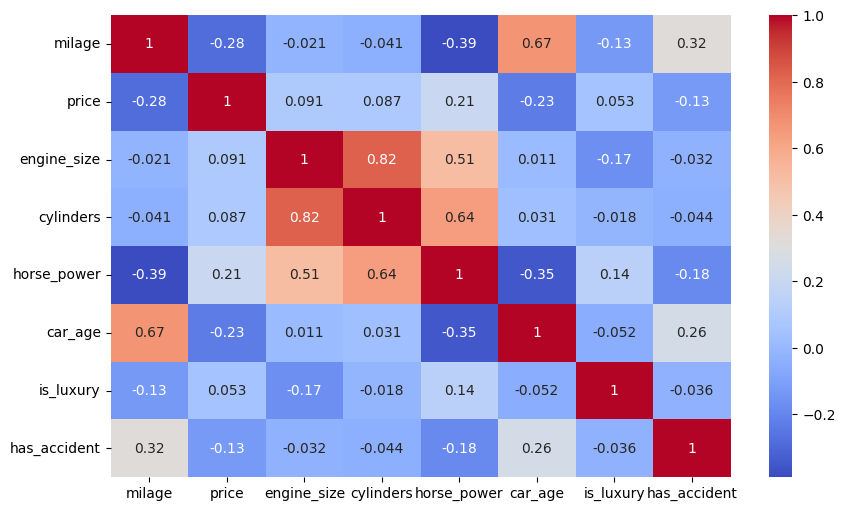

In [ ]:
# correlation heatmap
fig, ax = plt.subplots(figsize=(10, 6))
nuy = train.select_dtypes(include=['int', 'float'])
sns.heatmap(nuy.corr(), annot=True, cmap='coolwarm', ax=ax)
plt.show()

<Axes: xlabel='price', ylabel='Count'>

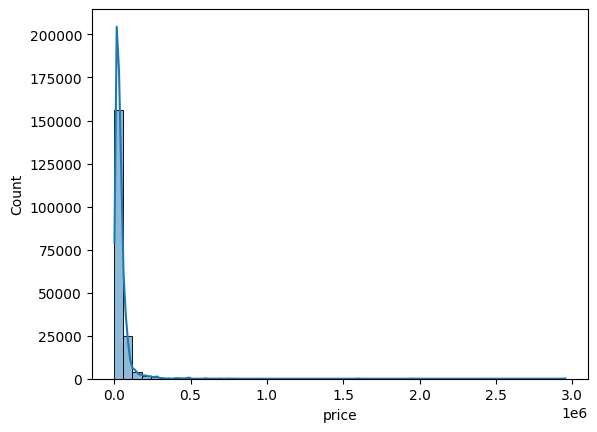

In [ ]:
# price distribution
sns.histplot(train['price'], bins=50, kde=True)

In [100]:
train['price'].describe([0.25, 0.50, 0.75, 0.90, 0.99])

,price
count,1.885330e+05
mean,4.387802e+04
std,7.881952e+04
min,2.000000e+03
25%,1.700000e+04
50%,3.082500e+04
75%,4.990000e+04
90%,7.850000e+04
99%,2.595000e+05
max,2.954083e+06


In [101]:
# masking to remove Outlier prices
train = train[train['price'] <= 1000000]
train = pd.get_dummies(train, columns=['fuel_type', 'gear_trans', 'mileage_bin'], drop_first=True, dtype=int)
train


,milage,price,engine_size,cylinders,horse_power,car_age,is_luxury,has_accident,fuel_type_E85,fuel_type_Gasoline,fuel_type_Hybrid,fuel_type_Others,gear_trans_CVT,gear_trans_Dual Clutch,gear_trans_Manual,gear_trans_Others,mileage_bin_Medium,mileage_bin_High
0,213000,4200,1.6,4.0,172.0,18,0,0,0,1,0,0,0,0,0,0,0,1
1,143250,4999,3.9,8.0,252.0,23,0,1,0,1,0,0,0,0,0,0,0,1
2,136731,13900,5.3,8.0,320.0,23,0,0,1,0,0,0,0,0,0,0,0,1
3,19500,45000,5.0,8.0,420.0,8,1,0,0,1,0,0,0,1,0,0,0,0
4,7388,97500,2.0,4.0,208.0,4,1,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,49000,27500,6.2,8.0,420.0,8,1,0,0,1,0,0,0,1,0,0,1,0
188529,28600,30000,3.0,6.0,385.0,7,1,1,0,1,0,0,0,0,0,0,0,0
188530,13650,86900,4.0,8.0,469.0,4,1,0,0,1,0,0,0,0,0,0,0,0
188531,13895,84900,3.0,6.0,329.0,3,1,0,0,1,0,0,0,0,0,0,0,0


<Axes: xlabel='price', ylabel='Count'>

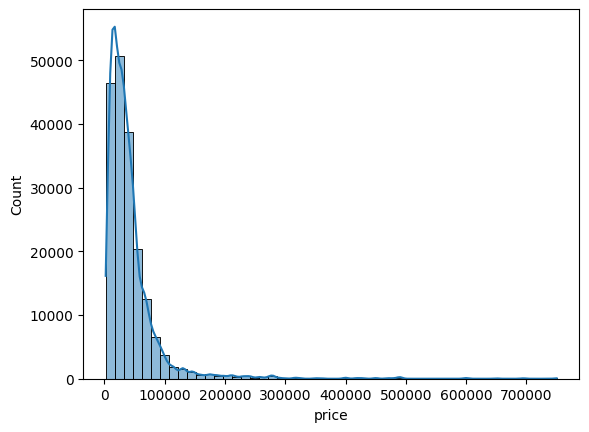

In [102]:
#train.price.plot(kind='hist', bins=50, title='Price Distribution')
sns.histplot(train['price'], bins=50, kde=True)

In [103]:
X = train.drop(columns=['price'])
y = train['price']

In [104]:
standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)
X

,milage,engine_size,cylinders,horse_power,car_age,is_luxury,has_accident,fuel_type_E85,fuel_type_Gasoline,fuel_type_Hybrid,fuel_type_Others,gear_trans_CVT,gear_trans_Dual Clutch,gear_trans_Manual,gear_trans_Others,mileage_bin_Medium,mileage_bin_High
0,2.957152,-1.671196,-1.644999,-1.618381,1.560169,-0.831196,-0.531991,-0.171852,0.320003,-0.201508,-0.065059,-0.103719,-0.337188,-0.308552,-0.053716,-0.745689,1.407300
1,1.556529,0.089606,1.217808,-0.850895,2.443605,-0.831196,1.879731,-0.171852,0.320003,-0.201508,-0.065059,-0.103719,-0.337188,-0.308552,-0.053716,-0.745689,1.407300
2,1.425623,1.161399,1.217808,-0.198531,2.443605,-0.831196,-0.531991,5.818959,-3.124976,-0.201508,-0.065059,-0.103719,-0.337188,-0.308552,-0.053716,-0.745689,1.407300
3,-0.928449,0.931729,1.217808,0.760827,-0.206702,1.203086,-0.531991,-0.171852,0.320003,-0.201508,-0.065059,-0.103719,2.965703,-0.308552,-0.053716,-0.745689,-0.710581
4,-1.171665,-1.364969,-1.644999,-1.273012,-0.913450,1.203086,-0.531991,-0.171852,0.320003,-0.201508,-0.065059,-0.103719,-0.337188,-0.308552,-0.053716,-0.745689,-0.710581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188380,-0.336070,1.850409,1.217808,0.760827,-0.206702,1.203086,-0.531991,-0.171852,0.320003,-0.201508,-0.065059,-0.103719,2.965703,-0.308552,-0.053716,1.341042,-0.710581
188381,-0.745715,-0.599403,-0.213595,0.425051,-0.383389,1.203086,1.879731,-0.171852,0.320003,-0.201508,-0.065059,-0.103719,-0.337188,-0.308552,-0.053716,-0.745689,-0.710581
188382,-1.045921,0.166163,1.217808,1.230912,-0.913450,1.203086,-0.531991,-0.171852,0.320003,-0.201508,-0.065059,-0.103719,-0.337188,-0.308552,-0.053716,-0.745689,-0.710581
188383,-1.041001,-0.599403,-0.213595,-0.112189,-1.090137,1.203086,-0.531991,-0.171852,0.320003,-0.201508,-0.065059,-0.103719,-0.337188,-0.308552,-0.053716,-0.745689,-0.710581


In [105]:
linear = LinearRegression()
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=11)
xgb = XGBRegressor(objective='reg:squarederror', random_state=11)
forest = RandomForestRegressor(random_state=11)
tree = DecisionTreeRegressor(random_state=11)
ridge = Ridge(random_state=11)
gradient = GradientBoostingRegressor(random_state=11)
cat = CatBoostRegressor(random_state=11, verbose=0)

models = [linear, xgb, forest, tree, ridge, gradient, cat]

In [106]:
for i in models:
    scores = cross_val_score(i, X, y, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    print(f"{i.__class__.__name__} RMSE: {rmse_scores.mean():.2f} (+/- {rmse_scores.std():.2f})")

LinearRegression RMSE: 42429.37 (+/- 1041.60)
XGBRegressor RMSE: 40424.76 (+/- 886.88)
RandomForestRegressor RMSE: 43717.53 (+/- 811.78)
DecisionTreeRegressor RMSE: 55397.43 (+/- 758.41)
Ridge RMSE: 42429.37 (+/- 1041.60)
GradientBoostingRegressor RMSE: 40592.72 (+/- 956.40)
CatBoostRegressor RMSE: 40061.36 (+/- 875.82)


In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

In [108]:
xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, pred)))

linear.fit(X_train, y_train)
pred = linear.predict(X_test)
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, pred)))

cat.fit(X_train, y_train)
pred = cat.predict(X_test)
print("CatBoost RMSE:", np.sqrt(mean_squared_error(y_test, pred)))

gradient.fit(X_train, y_train)
pred = gradient.predict(X_test)
print("Gradient RMSE:", np.sqrt(mean_squared_error(y_test, pred)))

ridge.fit(X_train, y_train)
pred = ridge.predict(X_test)
print("Ridge RMSE:", np.sqrt(mean_squared_error(y_test, pred)))

XGBoost RMSE: 41374.887842748285
Random Forest RMSE: 43398.76031400918
CatBoost RMSE: 40849.08700825633
Gradient RMSE: 41510.88550831933
Ridge RMSE: 43398.76350147876


In [ ]:
# Test Data Preprocessing

test = pd.read_csv("test.csv")
test['engine_size'] = test['engine'].str.extract(r'(\d+\.\d+)L').astype(float)
test['cylinders'] = test['engine'].str.extract(r'(\d+) Cylinder').astype(float)
test['horse_power'] = test['engine'].str.extract(r'(\d+\.\d+)HP').astype(float)
test.drop(columns=['engine', 'id'], inplace=True)
test['engine_size'].fillna(train['engine_size'].median(), inplace=True)
test['horse_power'].fillna(train['horse_power'].median(), inplace=True)

# creating "car age" column from the "model year" column
curr_time = datetime.datetime.now()
test['car_age'] = curr_time.year - test['model_year']

# luxury car brands
luxury_brands = ['BMW', 'Mercedes-Benz', 'Audi', 'Lexus', 'Porsche', 'Jaguar', 'Land Rover', 'Genesis', 'Cadillac', 'Tesla']
test['is_luxury'] = test['brand'].isin(luxury_brands).astype(int)

# Mileage bins
test['mileage_bin'] = pd.cut(test['milage'], bins=[0, 30000, 80000, float('inf')],
                              labels=['Low', 'Medium', 'High'])

# Handle accident column properly
test['has_accident'] = (test['accident'] == 'At least 1 accident or damage reported').astype(int)
test.drop(columns=['accident'], inplace=True)

# Transmission types
test['gear_trans'] = test['transmission'].apply(lambda i:
    "Automatic" if "a/t" in i.lower() or "auto" in i.lower() or "at" in i.lower() else
    "Manual" if "m/t" in i.lower() or "manual" in i.lower() or "mt" in i.lower() else
    "Dual Clutch" if "dual" in i.lower() or "dct" in i.lower() else
    "CVT" if "cvt" in i.lower() else
    "Others")

# filling missing values with median
test['engine_size'].fillna(test['engine_size'].median(), inplace=True)
test['horse_power'].fillna(test['horse_power'].median(), inplace=True)
test['cylinders'].fillna(test['cylinders'].median(), inplace=True)
test['fuel_type'].fillna(test['fuel_type'].mode()[0], inplace=True)

# Dropping unnecessary columns
test.drop(columns=['transmission', 'brand', 'model', 'clean_title', 'model_year', 'ext_col', 'int_col'], inplace=True)

# Standardizing fuel types
test['fuel_type'] = [
    'Gasoline' if 'gasoline' in str(i).lower() or 'petrol' in str(i).lower() else
    'Diesel' if 'diesel' in str(i).lower() else
    'Electric' if 'electric' in str(i).lower() or 'ev' in str(i).lower() else
    'Hybrid' if 'hybrid' in str(i).lower() else
    'E85' if 'e85' in str(i).lower() else
    'Others'
    for i in test['fuel_type']]

# encoding categorical variables
test = pd.get_dummies(test, columns=['fuel_type', 'gear_trans', 'mileage_bin'], drop_first=True, dtype=int)

# Aligning test set to train set
test = test.reindex(columns=X.columns, fill_value=0)
test_scaled = standard_scaler.transform(test)
test = pd.DataFrame(test_scaled, columns=test.columns)

test.head()
print(train.shape, test.shape)

(188385, 18) (125690, 17)


In [115]:
preds = cat.predict(test)
predictions = pd.DataFrame({'id': submission['id'], 'price': preds})
predictions.to_csv("submission.csv", index=False)